In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import h5py
import numpy as np
import json
from datetime import datetime

In [2]:
def projectDistZ(x1,x2,y1,y2,d12,z):
    mx = (x2-x1)/d12
    xProj = x1 + mx * z
    
    my = (y2-y1)/d12
    yProj = y1 + my * z
    
    return (xProj, yProj)

def get_theta_angles(x1, y1, x2, y2, d):
    import numpy as np
    thetaX = np.arctan((x2-x1)/d) #rad
    thetaY = np.arctan((y2-y1)/d) #rad
    return (thetaX, thetaY)


def file_loader(runs):
    """
    Load the data file for a given run number.
    """
    from collections.abc import Iterable
    
    if not isinstance(runs, Iterable):
        runs = [runs]

    pos = []
    infos = []
    phs = []
    tmis = []
    evis =[]
    nclus = []
    info_pluss =[]
    bases = []
    for run_number in runs:
        # data_path =f'../data/TB_T9_2025/run{run_number}.h5'
        data_path =f'/eos/project/i/insulab-como/testBeam/TB_2025_06_T9_epBOOST/HDF5/run{run_number}.h5'
        # print('\nopening ', data_path)
        pos = []
        phs = []
        tmis =[]
        qtots =[]
        nclus = []
        info_pluss =[]
        xinfos =[]
        with h5py.File(data_path, 'r', libver='latest', swmr=True) as hf:
            # print(hf.keys())
            hf["xpos"].shape
            keys = list(hf.keys())
            pos.append(np.array(hf['xpos']))
            phs.append(np.array(hf['digiPH'])) # from 24
            tmis.append(np.array(hf['digiTime'])) # from 24
            qtots.append(np.array(hf['qtot'])) # from 24
            nclus.append(np.array(hf['nclu'])) # from 24
            info_pluss.append(np.array(hf['info_plus']))
            xinfos.append(np.array(hf['xinfo']))
            #for k in hf.keys():
            #    comand = f'{k} = np.array(hf["{k}"])'
                # print(comand)
            #  exec(comand)
            # print(len(pos))
    xpos = np.concatenate(pos,axis=0)
    ph = np.concatenate(phs,axis=0)
    tm = np.concatenate(tmis,axis=0)
    qtot = np.concatenate(qtots,axis=0)
    nclu = np.concatenate(nclus,axis=0)
    info_plus = np.concatenate(info_pluss,axis=0)
    xinfo = np.concatenate(xinfos,axis=0)
    # print('xpos shape', xpos.shape)
    
    # print(np.unique(xinfo[:,1]))
        # print('xpos shape', xpos.shape)

    xpos[:,0]= xpos[:,0] - offset_x1 
    xpos[:,1]= xpos[:,1] - offset_y1 
    xpos[:,4]= xpos[:,4] - offset_x3 
    xpos[:,5]= xpos[:,5] - offset_y3 
    
    x1 = xpos[:,0]
    y1 = xpos[:,1]
    x2 = xpos[:,2] 
    y2 = xpos[:,3] 
    x3 = xpos[:,4]
    y3 = xpos[:,5]


    Calibration = False
    if Calibration:
        q = -25.84
        m = 323.4
        ph[:,2]=  (ph[:,2] - q)/m

    xcry, ycry = projectDistZ(x1,x2,y1,y2,d12,d1c)
    theta_x_in, theta_y_in = get_theta_angles(x1, y1, x2, y2, d12)
    theta_x_out, theta_y_out = get_theta_angles(xcry, ycry, x3, y3, dc3)


    ph_calo_photon = ph[:,2]
    ph_cherry1 = ph[:,0]
    print(f'{runs} -- N spill: {info_plus[:,0][-1]} -- events: {len(x1)} -- evs/spill: {len(x1)/info_plus[:,0][-1]:.0f}')
    return xpos, x1, y1, x2, y2, x3, y3, xcry, ycry, ph_calo_photon, ph_cherry1, \
    theta_x_in, theta_y_in, theta_x_out, theta_y_out, tm, qtot, nclu, info_plus,xinfo


In [3]:
d12 = 330 ## cm
d23 = 66.8
d1c = 330 + 53.2 #cm
dc3 = 10.7 
d1calo = d1c + 779.2 

offset_x1 =   0.107 #0.166
offset_y1 =   -2.21 #-2.336
offset_x3 =   0.484 #0.459
offset_y3 =   -2.053 #-2.031 

range_chamber = ((0,10),(0,10))
bins2d = (100,100)
mycmap = 'jet'

opt_hist = {'histtype': 'step', 'lw': 1.5, 'alpha': 0.8}
opts_2d = { "cmap" : mycmap, "bins" : bins2d} # "norm" : mpl.colors.LogNorm()}

th_cherry1 = 20
th_cherry2 = 20



In [4]:
import json
from datetime import datetime

# === Load run numbers ===
with open("multiple_run_new.json", "r") as f:
# with open("multiple_run-6GeV.json", "r") as f:
    run_list = json.load(f).get("scan_number", [])
# run_list = [730255 ,730256,730259,730260]
# === Load run configuration ===
with open("run_config.json", "r") as d:
    run_config = json.load(d)

# === Initialize dictionaries ===
x_cry_cuts = {}
y_cry_cuts = {}
samples = {}
types = {}
energies = {}

# === Fill dictionaries ===
for run in run_list:
    run_str = str(run)
    conf = run_config.get(run_str)
    if conf:
        x_cry_cuts[run] = conf.get("x_cry_cut")
        y_cry_cuts[run] = conf.get("y_cry_cut")
        samples[run] = conf.get("sample")
        types[run] = conf.get("type")
        energies[run] = conf.get("energy")
    else:
        print(f"⚠️ Run {run} not found in configuration file.")

# === Example usage ===
# print("✅ Loaded runs:", run_list)
# print("🔹 X cuts:", x_cry_cuts)
# print("🔹 Samples:", samples)

# === Timestamp ===
ora_attuale = datetime.now().strftime('%H:%M:%S')

print(f"Run numbers: {run_list} -- ultimo aggiornamento {ora_attuale}")

Run numbers: [730250, 730251, 730253, 730276] -- ultimo aggiornamento 08:31:01


In [5]:
# Opzione per applicare il taglio angolare
CutTheta = False

# Calcolo di theta_crit e theta_cut
theta_crit_dict = {}
theta_cut_dict = {}

for run in run_list:
    energy = float(energies[run])  # assicurati che sia float
    theta_crit = np.sqrt(2 * 887 / (energy * 1e9))  # in rad
    theta_crit_dict[run] = theta_crit

    # Disabilita il taglio per i run di tipo Conventional (nel sample o nel tipo)
    sample_str = samples[run].lower()
    type_str = types[run].lower()
    if "conventional" in sample_str or "conventional" in type_str:
        theta_cut = 1e11
    else:
        theta_cut = theta_crit if CutTheta else 1e11

    theta_cut_dict[run] = theta_cut

# Stampa riassuntiva in urad
print("\n🔍 Tagli angolari (theta_cut):")
for run in run_list:
    theta = theta_cut_dict[run]
    print(f"Run {run}: θ_cut = ± {theta * 1e6:.2f} µrad")



🔍 Tagli angolari (theta_cut):
Run 730250: θ_cut = ± 100000000000000000.00 µrad
Run 730251: θ_cut = ± 100000000000000000.00 µrad
Run 730253: θ_cut = ± 100000000000000000.00 µrad
Run 730276: θ_cut = ± 100000000000000000.00 µrad


[730250] -- N spill: 681 -- events: 49996 -- evs/spill: 73
Run 730250 -- W15mm 2.86GeV: Δx = 0.500 cm, Δy = 0.500 cm, Area = 0.250 cm²
events after cuts: 46464, discarded events : 7.06%

[730251] -- N spill: 50 -- events: 4623 -- evs/spill: 92
Run 730251 -- W15mm 2.86GeV: Δx = 0.500 cm, Δy = 0.500 cm, Area = 0.250 cm²
events after cuts: 4323, discarded events : 6.49%

[730253] -- N spill: 1982 -- events: 194553 -- evs/spill: 98
Run 730253 -- W12mm 2.86GeV: Δx = 0.500 cm, Δy = 0.500 cm, Area = 0.250 cm²
events after cuts: 181694, discarded events : 6.61%

[730276] -- N spill: 1722 -- events: 176718 -- evs/spill: 103
Run 730276 -- W12 2.86GeV: Δx = 0.500 cm, Δy = 0.500 cm, Area = 0.250 cm²
events after cuts: 165760, discarded events : 6.20%



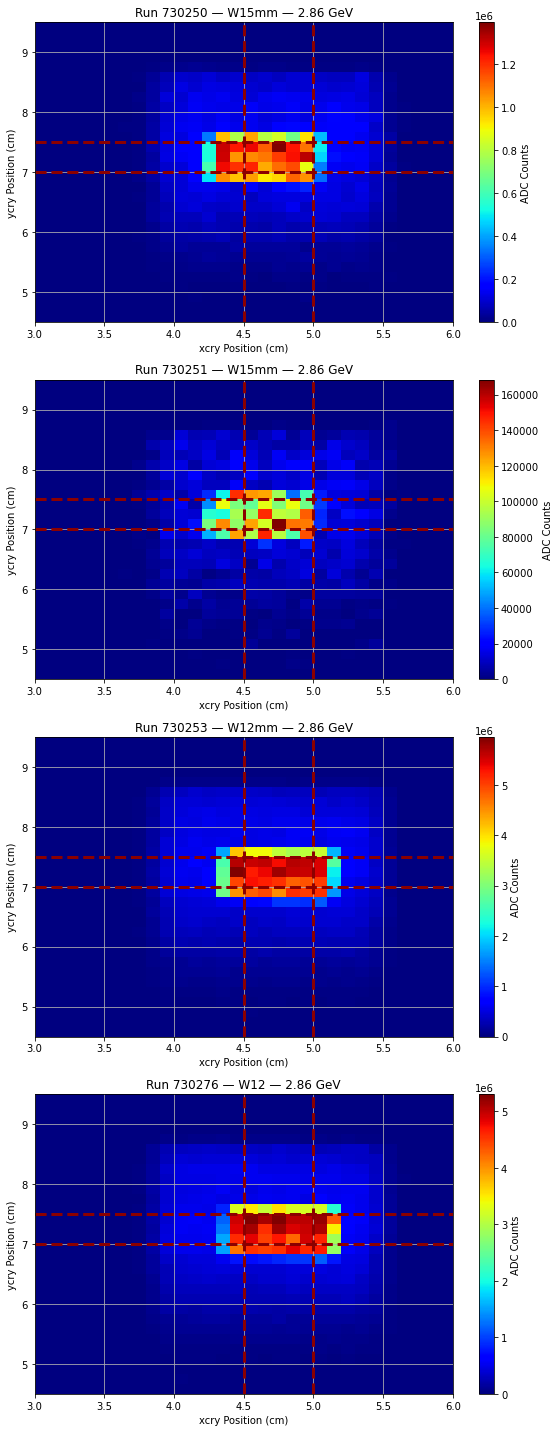

In [6]:
# === Plot settings ===
fig, ax = plt.subplots(len(run_list), figsize=(8, 5 * len(run_list)))
if len(run_list) == 1:
    ax = [ax]  # uniforma sempre la struttura

for j, run in enumerate(run_list):
    # === Load data ===
    (xpos, x1, y1, x2, y2, x3, y3, xcry, ycry, ph_calo_photon, ph_cherry1,
     theta_x_in, theta_y_in, theta_x_out, theta_y_out, tm, qtot, nclu,
     info_plus, xinfo) = file_loader(run)

    # === Build selection mask ===
    mask = (
        (ph_cherry1 > th_cherry1) &
        ((theta_x_in**2 + theta_y_in**2) < (theta_cut_dict[run]**2))
    )

    # === Plot 2D histogram ===
    h = ax[j].hist2d(
        xcry[mask], ycry[mask],
        range=((3, 6), (4.5 ,9.5 )),
        weights=qtot[:, 0][mask],
        cmap=mycmap,
        bins=30
    )

    # === Decorations ===
    ax[j].set_title(f"Run {run} — {samples[run]} — {energies[run]} GeV")
    ax[j].set_xlabel("xcry Position (cm)")
    ax[j].set_ylabel("ycry Position (cm)")
    ax[j].grid(True)

    # === Show selection box ===
    x_min, x_max = x_cry_cuts[run]
    y_min, y_max = y_cry_cuts[run]
    dx, dy = x_max - x_min, y_max - y_min
    ax[j].axvline(x=x_min, color='darkred', linestyle='--', lw=3)
    ax[j].axvline(x=x_max, color='darkred', linestyle='--', lw=3)
    ax[j].axhline(y=y_min, color='darkred', linestyle='--', lw=3)
    ax[j].axhline(y=y_max, color='darkred', linestyle='--', lw=3)

    # === Print area info ===
    print(f"Run {run} -- {samples[run]} {energies[run]}GeV: Δx = {dx:.3f} cm, Δy = {dy:.3f} cm, Area = {dx * dy:.3f} cm²")
    print(f'events after cuts: {np.sum(mask)}, discarded events : {100*(1-np.sum(mask)/np.size(mask)):.2f}%\n')
    # === Add colorbar ===
    plt.colorbar(h[3], ax=ax[j], label='ADC Counts')
    
# === Layout and show ===
plt.tight_layout()
plt.show()


[730250] -- N spill: 681 -- events: 49996 -- evs/spill: 73
[730251] -- N spill: 50 -- events: 4623 -- evs/spill: 92
[730253] -- N spill: 1982 -- events: 194553 -- evs/spill: 98
[730276] -- N spill: 1722 -- events: 176718 -- evs/spill: 103


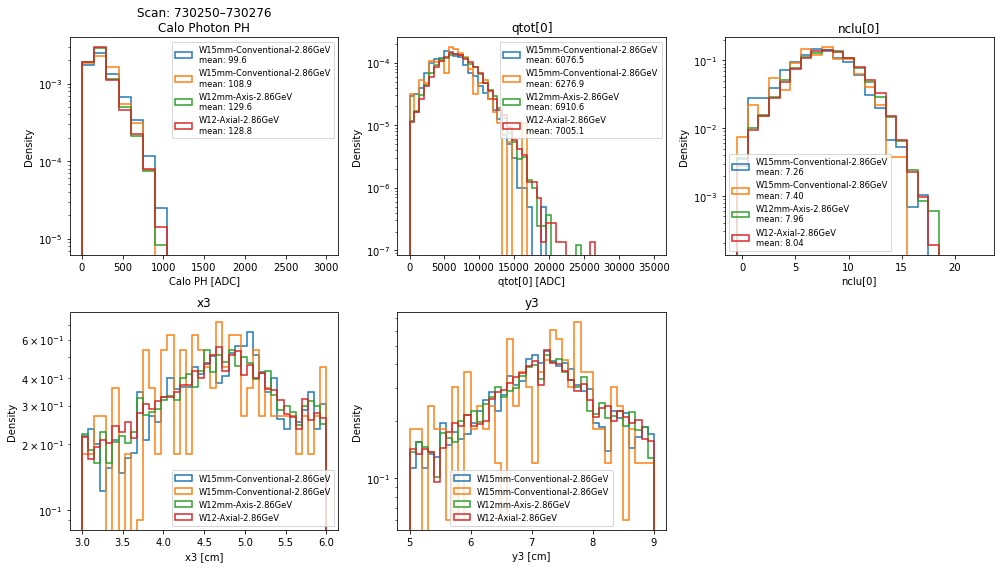

In [7]:
opt_hist = dict(histtype='step', linewidth=1.5)

fig, axs = plt.subplots(2, 3, figsize=(14, 8), sharey=False)
axs = axs.flatten()

means_nclu3 = {}
means_qtot3 = {}

for j, run in enumerate(run_list):
    # === Load data ===
    (xpos, x1, y1, x2, y2, x3, y3, xcry, ycry, ph_calo_photon, ph_cherry1,
     theta_x_in, theta_y_in, theta_x_out, theta_y_out, tm, qtot, nclu,
     info_plus, xinfo) = file_loader(run)

    # === Get cuts from dicts ===
    x_cry_cut = x_cry_cuts[run]
    y_cry_cut = y_cry_cuts[run]
    theta_cut = theta_cut_dict[run]

    # === Selection mask ===
    logi = (
        (ph_cherry1 > th_cherry1) &
        (xcry > x_cry_cut[0]) & (xcry < x_cry_cut[1]) &
        (ycry > y_cry_cut[0]) & (ycry < y_cry_cut[1]) &
        ((theta_x_in**2 + theta_y_in**2) < (theta_cut_dict[run]**2))
    )
    logi_calo = ph_calo_photon > 100
    if np.sum(logi) == 0:
        continue

    label = f"{samples[run]}-{types[run]}-{energies[run]}GeV"

    axs[0].hist(ph_calo_photon[logi & logi_calo], bins=20, range=(0, 3000),
                label=f'{label}\nmean: {np.mean(ph_calo_photon[logi]):.1f}', density=True, **opt_hist)
    axs[1].hist(qtot[:, 0][logi], bins=50, range=(0, 35000),
                label=f'{label}\nmean: {np.mean(qtot[:, 0][logi]):.1f}', density=True, **opt_hist)
    axs[2].hist(nclu[:, 0][logi], bins=np.arange(-0.5, np.max(nclu[:, 0]) + 0.5, 1),
                label=f'{label}\nmean: {np.mean(nclu[:, 0][logi]):.2f}', density=True, **opt_hist)
    axs[3].hist(x3[logi], bins=40, range=(3, 6), label=label, density=True, **opt_hist)
    axs[4].hist(y3[logi], bins=40, range=(5, 9), label=label, density=True, **opt_hist)

    valid = logi & (nclu[:, 0] > 0)
    means_nclu3[label] = np.mean(nclu[:, 0][valid])
    means_qtot3[label] = np.mean(qtot[:, 0][valid])

# === Titles and labels ===
axs[0].set_title(f'Scan: {run_list[0]}–{run_list[-1]}\nCalo Photon PH')
axs[1].set_title('qtot[0]')
axs[2].set_title('nclu[0]')
axs[3].set_title('x3')
axs[4].set_title('y3')

labels = ['Calo PH [ADC]', 'qtot[0] [ADC]', 'nclu[0]', 'x3 [cm]', 'y3 [cm]']
for j in range(5):
    axs[j].set_xlabel(labels[j])
    axs[j].set_ylabel('Density')
    axs[j].legend(fontsize='small')
    axs[j].set_yscale('log')  # scommenta se vuoi scala log

axs[5].axis('off')  # Subplot vuoto disattivato

plt.tight_layout()
plt.show()


In [8]:
def canonical_type(t):
    return t.strip() if t.strip() else "Conventional"

def get_label(run):
    typ = canonical_type(types[run])
    return f"{samples[run]}-{typ}-{energies[run]}GeV"


In [9]:
print("########## RATIOS ##########\n")

energies_present = sorted({energies[run] for run in run_list})

for energy in energies_present:
    axis_label = amorph_label = conv_label = None

    for run in run_list:
        if energies[run] != energy:
            continue

        typ = canonical_type(types[run])
        label = get_label(run)

        if typ == "Axis":
            axis_label = label
        elif typ == "Amorphous":
            amorph_label = label
        elif typ == "Conventional":
            conv_label = label

    print(f"--- Energy: {energy} GeV ---")

    # Axis / Amorphous
    if axis_label and amorph_label:
        if axis_label in means_nclu3 and amorph_label in means_nclu3:
            print(f"NCLU Axis / Amorphous = {100 * means_nclu3[axis_label] / means_nclu3[amorph_label]:.2f}%")
        if axis_label in means_qtot3 and amorph_label in means_qtot3:
            print(f"QTOT Axis / Amorphous = {100 * means_qtot3[axis_label] / means_qtot3[amorph_label]:.2f}%")

    # Axis / Conventional
    if axis_label and conv_label:
        if axis_label in means_nclu3 and conv_label in means_nclu3:
            print(f"NCLU Axis / Conventional = {100 * means_nclu3[axis_label] / means_nclu3[conv_label]:.2f}%")
        if axis_label in means_qtot3 and conv_label in means_qtot3:
            print(f"QTOT Axis / Conventional = {100 * means_qtot3[axis_label] / means_qtot3[conv_label]:.2f}%")

    # Amorphous / Conventional
    if amorph_label and conv_label:
        if amorph_label in means_nclu3 and conv_label in means_nclu3:
            print(f"NCLU Amorphous / Conventional = {100 * means_nclu3[amorph_label] / means_nclu3[conv_label]:.2f}%")
        if amorph_label in means_qtot3 and conv_label in means_qtot3:
            print(f"QTOT Amorphous / Conventional = {100 * means_qtot3[amorph_label] / means_qtot3[conv_label]:.2f}%")

    print()

print("#############################")


########## RATIOS ##########

--- Energy: 2.86 GeV ---
NCLU Axis / Conventional = 107.26%
QTOT Axis / Conventional = 109.67%

#############################


[730250] -- N spill: 681 -- events: 49996 -- evs/spill: 73
[730251] -- N spill: 50 -- events: 4623 -- evs/spill: 92
[730253] -- N spill: 1982 -- events: 194553 -- evs/spill: 98
[730276] -- N spill: 1724 -- events: 176718 -- evs/spill: 103


IndexError: boolean index did not match indexed array along dimension 0; dimension is 176933 but corresponding boolean dimension is 176718

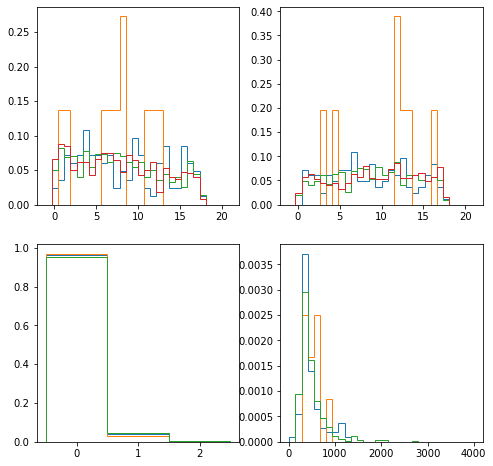

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
ax = ax.flatten()
iWantDensity = True

means_nclu4 = {}
means_qtot4 = {}

for run in run_list:
    if run > 730198:
        # === Load data ===
        xpos, x1, y1, x2, y2, x3, y3, xcry, ycry, ph_calo_photon, ph_cherry1, \
        theta_x_in, theta_y_in, theta_x_out, theta_y_out, tm, qtot, nclu, info_plus, xinfo = file_loader(run)

        # === Get cuts ===
        x_cry_cut = x_cry_cuts[run]
        y_cry_cut = y_cry_cuts[run]
        theta_cut = theta_cut_dict[run]

        # === Build mask ===
        mask = (
            (ph_cherry1 > th_cherry1) &
            (xcry > x_cry_cut[0]) & (xcry < x_cry_cut[1]) &
            (ycry > y_cry_cut[0]) & (ycry < y_cry_cut[1]) &
            ((theta_x_in**2 + theta_y_in**2) < (theta_cut_dict[run]**2))
        )

        # === Get position vectors for detector 4 ===
        x4 = xpos[:, 6]
        y4 = xpos[:, 7]

        # === Label ===
        label = f"{samples[run]}-{canonical_type(types[run])}-{energies[run]}GeV"

        # === Plots ===
        ax[0].hist(x4[mask], bins=30, range=(-1, 21), histtype='step', density=iWantDensity, label=label)
        ax[1].hist(y4[mask], bins=30, range=(-1, 21), histtype='step', density=iWantDensity, label=label)
        ax[2].hist(nclu[:, 2][mask], bins=np.arange(-0.5, round(np.max(nclu[:, 2])) + 0.5, 1),
                   histtype='step', density=iWantDensity, label=f'{label} — mean {np.mean(nclu[:, 2][mask]):.4f}')
        ax[3].hist(qtot[:, 2][mask], bins=30, range=(10, 4000), histtype='step', density=iWantDensity,
                   label=f'{label} — mean {np.mean(qtot[:, 2][mask]):.1f}')

        # === Store means only if nclu > 0 ===
        valid = mask & (nclu[:, 2] > 0)
        means_nclu4[label] = np.mean(nclu[:, 2][valid])
        means_qtot4[label] = np.mean(qtot[:, 2][valid])

# === Axis formatting ===
ax[0].set_title('X4')
ax[0].set_xlabel('X4 [cm]')
ax[1].set_title('Y4')
ax[1].set_xlabel('Y4 [cm]')
ax[2].set_title('Nclu4')
ax[2].set_xlabel('Nclu')
ax[3].set_title('Qtot4')
ax[3].set_xlabel('Qtot [ADC]')
ax[3].set_yscale('log')

for a in ax:
    a.legend(fontsize='small')

plt.tight_layout()
plt.show()


In [ ]:
print("########## RATIOS ##########\n")

# Trova energie presenti
energies_present = sorted({energies[run] for run in run_list if run in x_cry_cuts})

for energy in energies_present:
    axis_label = amorph_label = conv_label = None

    for run in run_list:
        if energies[run] != energy:
            continue

        typ = canonical_type(types[run])
        label = get_label(run)

        if typ == "Axis":
            axis_label = label
        elif typ == "Amorphous":
            amorph_label = label
        elif typ == "Conventional":
            conv_label = label

    print(f"--- Energy: {energy} GeV ---")

    if axis_label and amorph_label:
        if axis_label in means_nclu4 and amorph_label in means_nclu4:
            print(f"NCLU Axis / Amorphous = {100 * means_nclu4[axis_label] / means_nclu4[amorph_label]:.2f}%")
        if axis_label in means_qtot4 and amorph_label in means_qtot4:
            print(f"QTOT Axis / Amorphous = {100 * means_qtot4[axis_label] / means_qtot4[amorph_label]:.2f}%")

    if axis_label and conv_label:
        if axis_label in means_nclu4 and conv_label in means_nclu4:
            print(f"NCLU Axis / Conventional = {100 * means_nclu4[axis_label] / means_nclu4[conv_label]:.2f}%")
        if axis_label in means_qtot4 and conv_label in means_qtot4:
            print(f"QTOT Axis / Conventional = {100 * means_qtot4[axis_label] / means_qtot4[conv_label]:.2f}%")

    if amorph_label and conv_label:
        if amorph_label in means_nclu4 and conv_label in means_nclu4:
            print(f"NCLU Amorphous / Conventional = {100 * means_nclu4[amorph_label] / means_nclu4[conv_label]:.2f}%")
        if amorph_label in means_qtot4 and conv_label in means_qtot4:
            print(f"QTOT Amorphous / Conventional = {100 * means_qtot4[amorph_label] / means_qtot4[conv_label]:.2f}%")

    print()

print("#############################")